In [1]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics deepface matplotlib opencv-python-headless numpy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━


0: 448x640 1 person, 165.6ms
Speed: 3.0ms preprocess, 165.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
25-06-05 07:43:14 - Found 0 newly added image(s), 0 removed image(s), 7 replaced image(s).


Finding representations: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


25-06-05 07:43:21 - There are now 8 representations in ds_model_arcface_detector_opencv_aligned_normalization_base_expand_0.pkl
25-06-05 07:43:21 - Searching temp_face.jpg in 8 length datastore
25-06-05 07:43:21 - find function duration 7.9519782066345215 seconds


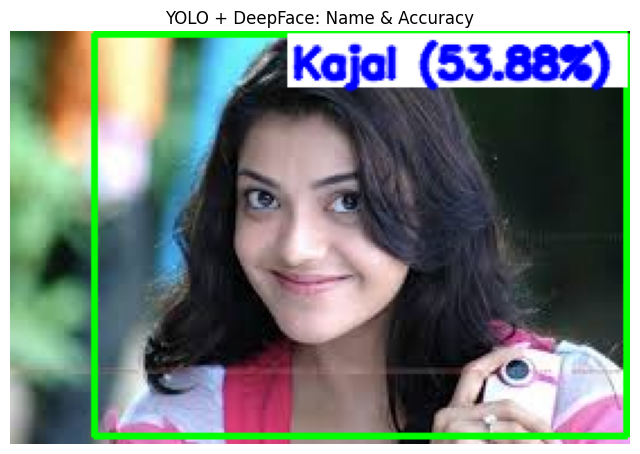

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from ultralytics import YOLO
import os

def detect_and_label(image_path, db_path, model_name='ArcFace', detector='retinaface', threshold=0.8):
    image = cv2.imread(image_path)
    model = YOLO("yolov8n.pt")
    results = model(image)[0]
    person_boxes = [box for box in results.boxes if int(box.cls[0]) == 0]

    for box in person_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        person_crop = image[y1:y2, x1:x2]

        try:
            face_results = DeepFace.extract_faces(person_crop, detector_backend=detector, enforce_detection=False)
            if face_results:
                face = face_results[0]['face']
                face = (face * 255).astype(np.uint8)
                face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                cv2.imwrite("temp_face.jpg", face)
                df = DeepFace.find(img_path="temp_face.jpg", db_path=db_path, model_name=model_name, enforce_detection=False)
                if len(df) > 0 and not df[0].empty:
                    match = df[0].iloc[0]
                    name = os.path.basename(match['identity']).split('.')[0]
                    accuracy = round(100 - match['distance'] * 100, 2)
                    label = f"{name} ({accuracy}%)"
                else:
                    label = "Unknown"
            else:
                label = "No Face"
        except:
            label = "Error"

        # Draw full person bounding box
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

        # Label at top-right of bounding box line
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        text_thickness = 2
        text_size = cv2.getTextSize(label, font, font_scale, text_thickness)[0]

        # Text background box
        text_origin = (x2 - text_size[0] - 5, y1 + text_size[1] + 5)
        cv2.rectangle(
            image,
            (text_origin[0] - 2, y1),
            (x2, text_origin[1] + 4),
            (255, 255, 255),
            cv2.FILLED
        )
        # Draw text
        cv2.putText(
            image,
            label,
            (text_origin[0], text_origin[1]),
            font,
            font_scale,
            (255, 0, 0),
            text_thickness,
            cv2.LINE_AA
        )

    # Show result
    plt.figure(figsize=(8, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("YOLO + DeepFace: Name & Accuracy")
    plt.axis("off")
    plt.show()

#  Run it
detect_and_label(
    image_path="/content/drive/MyDrive/human face recognition/test5.jpg",
    db_path="/content/drive/MyDrive/human face recognition/known_faces",
    model_name="ArcFace"
)
